# Test de mémoire longue sur RNN/LSTM

Ce notebook teste si les RNN/LSTM peuvent capturer la mémoire longue d'une série ARFIMA.

## 🔧 Corrections appliquées

Les corrections suivantes ont été appliquées pour résoudre le bug de dimensions :

1. **`utils.py`** : `create_dataset()` supporte maintenant les données multidimensionnelles
2. **`train.py`** : Détection automatique des dimensions d'entrée/sortie
3. **Modèles** : Support des embeddings et architectures multi-couches

## 📋 Plan du notebook

1. Génération d'une série ARFIMA avec paramètre de mémoire longue $d = 0.4$
2. **Test 1** : Entraîner un RNN sur la série brute
3. **Test 2** : Entraîner un RNN sur la série embeddée (ts2vec)
4. Extraction des hidden states et test de mémoire longue
5. **Test de contrôle** : RNN non entraîné pour validation

## Import des packages

In [25]:
import sys
sys.path.append('..')

import torch
from _arfima import arfima
from d_test import compute_total_memory
from ts2vec.encoder import extract_ts2vec_features
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time_series_prediction.train as train
import layers

## Génération de la série ARFIMA

In [40]:
# Paramètres de la série ARFIMA
params = {
    'd': 0.4,  # Paramètre de mémoire longue
    'n_points': 2**16,
    'ar_params': [0.7, -0.4],
    'ma_params': [0.2],
    'warmup': 2**10,
    'noise_std': 1,
    'noise_alpha': 2,
}

# Génération de la série
np.random.seed(42)
series = arfima(
    params["ar_params"],
    params["d"],
    params["ma_params"],
    params["n_points"],
    warmup=params["warmup"],
    noise_std=params["noise_std"],
    noise_alpha=params["noise_alpha"]
)

print(f"Série générée : {len(series)} points")
print(f"Moyenne : {series.mean():.3f}, Std : {series.std():.3f}")

Série générée : 65536 points
Moyenne : 0.069, Std : 2.287


## Visualisation de la série

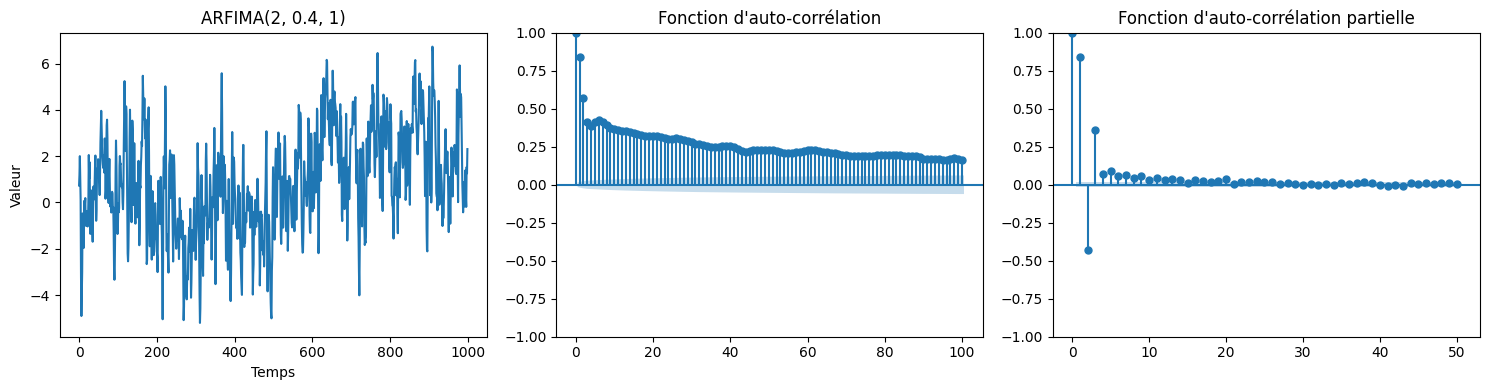

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Série temporelle
axes[0].plot(series[:1000])
axes[0].set_title(f'ARFIMA({len(params["ar_params"])}, {params["d"]}, {len(params["ma_params"])})')
axes[0].set_xlabel('Temps')
axes[0].set_ylabel('Valeur')

# ACF
plot_acf(series, lags=100, ax=axes[1])
axes[1].set_title('Fonction d\'auto-corrélation')

# PACF
plot_pacf(series, lags=50, ax=axes[2])
axes[2].set_title('Fonction d\'auto-corrélation partielle')

plt.tight_layout()
plt.show()

## Entraînement du modèle mRNN-mLSTM

In [71]:
ts_emb = extract_ts2vec_features(series, output_dims=50)

In [ ]:
# Recharger le module d'entraînement
import importlib
importlib.reload(train)
importlib.reload(layers)

# Entraîner le modèle sur la série ARFIMA
print("Démarrage de l'entraînement...")

# Paramètres du modèle
rmse, values, predictions, model, scaler = train.train_model(
    dataset=ts_emb,              # Série embeddée (50, 65536)
    algorithm='RNN',            # Algorithme: 'RNN', 'LSTM', 'mRNN_fixD', 'mLSTM_fixD', 'mRNN', 'mLSTM'
    epochs=5,                  # Nombre d'époques
    lr=0.01,                     # Learning rate
    hidden_size=64,              # Taille de la couche cachée
    input_size=50,               # ✅ Dimension de l'embedding (sera auto-détectée)
    output_size=50,              # ✅ Dimension de sortie (sera auto-détectée)
    K=100,                       # Troncature de la sommation infinie
    num_layers=1,                # ✅ Commencer avec 1 couche
    embedding_dim=None,          # ✅ Pas d'embedding supplémentaire (déjà embeddé)
    patience=50,                 # Patience pour l'early stopping
    train_size=int(0.7*len(series)),   # 70% pour l'entraînement
    validate_size=int(0.15*len(series)),  # 15% pour la validation
    start=0,                     # Graine de départ
    end=1,                       # Nombre de runs (1 seul run)
    verbose=True                 # Afficher les détails d'entraînement
)

print(f"\n✓ Entraînement terminé!")
print(f"RMSE final : {rmse:.4f}")
print(f"Nombre de valeurs de test : {len(values)}")
print(f"Nombre de prédictions : {len(predictions)}")

Démarrage de l'entraînement...
seed ---------------------------------- 0
epoch:  0 train_loss: 0.26942 val_loss: 2.26824  time: 12.5s
epoch:  1 train_loss: 2.27640 val_loss: 1.71952  time: 15.1s
epoch:  2 train_loss: 1.71195 val_loss: 0.11026  time: 18.9s
epoch:  3 train_loss: 0.10848 val_loss: 0.00380  time: 12.4s
epoch:  4 train_loss: 0.00392 val_loss: 0.02327  time: 12.0s


### Test 1 : RNN sur série brute (sans embedding)

Pour établir une baseline, entraînons d'abord un RNN sur la série ARFIMA brute.

In [ ]:
# Test 1: Entraîner sur la série brute
print("Test 1: Entraînement sur série ARFIMA brute (input_size=1)")
print("="*70)

rmse_raw, values_raw, predictions_raw, model_raw, scaler_raw = train.train_model(
    dataset=series,              # ✅ Série brute (65536,)
    algorithm='RNN',
    epochs=5,
    lr=0.01,
    hidden_size=64,
    input_size=1,                # ✅ Série univariée
    output_size=1,
    num_layers=1,
    embedding_dim=None,          # ✅ Pas d'embedding
    patience=50,
    train_size=int(0.7*len(series)),
    validate_size=int(0.15*len(series)),
    start=0,
    end=1,
    verbose=True
)

print(f"\n✓ Test 1 terminé - RMSE: {rmse_raw:.4f}")

### Test 2 : RNN sur série embeddée (ts2vec)

Maintenant testons sur la série pré-embeddée avec ts2vec.

In [ ]:
# Test 2: Entraîner sur la série embeddée
print("\nTest 2: Entraînement sur série embeddée ts2vec (input_size=50)")
print("="*70)
print(f"Shape de ts_emb: {ts_emb.shape}")

rmse_emb, values_emb, predictions_emb, model_emb, scaler_emb = train.train_model(
    dataset=ts_emb,              # ✅ Série embeddée (50, 65536)
    algorithm='RNN',
    epochs=5,
    lr=0.01,
    hidden_size=64,
    input_size=50,               # ✅ Sera auto-détecté
    output_size=50,              # ✅ Sera auto-détecté
    num_layers=1,
    embedding_dim=None,          # ✅ Déjà embeddé
    patience=50,
    train_size=int(0.7*len(series)),
    validate_size=int(0.15*len(series)),
    start=0,
    end=1,
    verbose=True
)

print(f"\n✓ Test 2 terminé - RMSE: {rmse_emb:.4f}")
print(f"\nComparaison:")
print(f"  - RMSE série brute:    {rmse_raw:.4f}")
print(f"  - RMSE série embeddée: {rmse_emb:.4f}")

## Extraction des états cachés et test de mémoire longue

Maintenant, extrayons les hidden states du modèle entraîné sur la série brute et testons s'ils capturent la mémoire longue.

In [ ]:
# Extraire les hidden states du modèle entraîné sur la série BRUTE
print("Extraction des hidden states du RNN...")

# Méthode 1: Utiliser toute la série normalisée
init_hidden = torch.zeros(model_raw.num_layers, 1, model_raw.hidden_size)

with torch.no_grad():
    # Normaliser TOUTE la série (pas juste le test set)
    series_scaled = scaler_raw.transform(series.reshape(-1, 1)).flatten()
    
    # Passer la série complète dans le RNN
    hidden = model_raw.rnn(
        torch.tensor(series_scaled).view(len(series_scaled), 1, 1).float(), 
        init_hidden
    )[0]

# Convertir en format (hidden_size, T) pour le test
hidden_np = hidden.squeeze().t().numpy()

print(f"Shape des hidden states: {hidden_np.shape}")
print(f"  - {hidden_np.shape[0]} dimensions (hidden_size)")
print(f"  - {hidden_np.shape[1]} pas de temps")

In [ ]:
# Test de mémoire longue sur les hidden states
print("\nTest de mémoire longue sur les hidden states du RNN...")
print("="*70)

# Tester sur les 50 premières dimensions (comme dans le papier)
n_dims = min(50, hidden_np.shape[0])

import time
start = time.time()
d_hidden, a_var_hidden, p_val_hidden = compute_total_memory(hidden_np[:n_dims, :])

print(f'Temps de calcul: {np.around(time.time()-start, 2)} s')
print('-'*70)
print(f'Mémoire totale des hidden states: d = {np.around(d_hidden, 4)}')
print(f'Variance asymptotique: {np.around(a_var_hidden, 6)}')
print(f'p-value (H0: d=0): {np.around(p_val_hidden, 4)}')
print('-'*70)

# Comparaison
print(f"\n📊 Comparaison:")
print(f"  - Mémoire de la série ARFIMA d'entrée: d = {params['d']}")
print(f"  - Mémoire capturée par le RNN:         d = {np.around(d_hidden, 4)}")

if p_val_hidden < 0.05:
    print(f"\n✓ Le RNN a capturé une mémoire longue significative (p < 0.05)!")
    if abs(d_hidden - params['d']) < 0.15:
        print(f"✓✓ La mémoire capturée est proche de celle de l'entrée (Δd < 0.15)!")
else:
    print(f"\n✗ Pas de mémoire longue significative détectée (p >= 0.05).")

### Test de contrôle : RNN non entraîné

Pour valider que c'est bien l'entraînement qui capture la mémoire longue (et pas juste l'architecture), testons un RNN **non entraîné** sur la même série.

In [ ]:
# Créer un RNN non entraîné (poids aléatoires)
import time_series_prediction.models as models

untrained_model = models.RNN(
    input_size=1, 
    hidden_size=64, 
    output_size=1,
    num_layers=1
)

print("Test sur RNN NON ENTRAÎNÉ (poids aléatoires)")
print("="*70)

# Extraire hidden states
init_hidden_untrained = torch.zeros(1, 1, 64)

with torch.no_grad():
    series_scaled = scaler_raw.transform(series.reshape(-1, 1)).flatten()
    hidden_untrained = untrained_model.rnn(
        torch.tensor(series_scaled).view(len(series_scaled), 1, 1).float(),
        init_hidden_untrained
    )[0]

hidden_untrained_np = hidden_untrained.squeeze().t().numpy()

# Test de mémoire longue
start = time.time()
d_untrained, a_var_untrained, p_val_untrained = compute_total_memory(hidden_untrained_np[:50, :])

print(f'Temps de calcul: {np.around(time.time()-start, 2)} s')
print('-'*70)
print(f'Mémoire totale (RNN non entraîné): d = {np.around(d_untrained, 4)}')
print(f'p-value: {np.around(p_val_untrained, 4)}')
print('-'*70)

print(f"\n📊 Comparaison finale:")
print(f"  - Série ARFIMA d'entrée:  d = {params['d']}")
print(f"  - RNN entraîné:          d = {np.around(d_hidden, 4)} (p={p_val_hidden:.4f})")
print(f"  - RNN non entraîné:      d = {np.around(d_untrained, 4)} (p={p_val_untrained:.4f})")

if p_val_hidden < 0.05 and p_val_untrained >= 0.05:
    print(f"\n✓✓ L'ENTRAÎNEMENT a permis de capturer la mémoire longue!")
elif p_val_hidden < 0.05 and p_val_untrained < 0.05:
    print(f"\n⚠️ Les deux modèles capturent de la mémoire longue (effet architectural?)")
else:
    print(f"\n✗ Aucun modèle ne capture significativement la mémoire longue")

## Chargement données

In [ ]:
df = pd.read_excel('south_sea_level.xlsx', sheet_name=None)['Pacific-Area-km^2'].drop(columns=['month', 'day'])

In [ ]:
df.to_csv('ocean_level_data.csv', index=False)

In [ ]:
ts = []

for col in df.columns:
    values = df[col].dropna().values
    ts.extend(values)


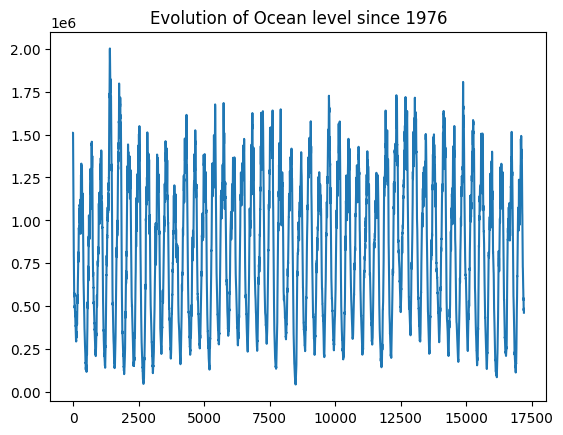

In [ ]:
plt.plot(ts)
plt.title('Evolution of Ocean level since 1976')
plt.show()

In [ ]:
ts_emb = extract_ts2vec_features(ts)
d_est, var_est, p_val = compute_total_memory(ts_emb)

c:\Users\33768\Desktop\ENSAE\Cours\Advanced ML\LSTM-long-memory\Recherche clément\d_test.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, :, i - 1] = np.outer(seq_fft[:, i], np.conj(seq_fft[:, i]))


In [ ]:
ts_emb.shape

(50, 17205)

In [ ]:
p_val

0.011635608383402607